In [1]:
import paddle
import cv2
import time
import os
import sys
#import torch
#from torch import nn, optim
#import torchvision
import numpy as np
import glob as glob
from matplotlib import pyplot as plt
import math
import json
import os
import logging
import datetime
#device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

#print(torch.__version__)
#print(torchvision.__version__)
#print(device)


print(paddle.__version__)
print(cv2.__version__)
!ls

2.0.1
3.4.2
 copy-Copy1.ipynb		      stitch_surf_cylinder_final2.ipynb
 cyl.jpg			      stitch_surf_cylinder.ipynb
 dachuangfangmian.tar		      stitch_surf.ipynb
 final_im_c.png			      Untitled1111.ipynb
 final_im_end.png		      Untitled1.ipynb
 final_im.png			      Untitled.ipynb
 infer2label.py			      work
 output				      yolo_3-Copy1.ipynb
 PaddleDetection		      yolo_3.ipynb
 PaddleDetection-release-2.0-rc.zip   yolo_mosaic_1.ipynb
 pic				      yolo_mosaic_2.ipynb
 stitch_sift.ipynb		      yolo_mosaic_end.ipynb
'stitch_surf(1).ipynb'


In [2]:
def box_iou_xyxy(box1, box2):
    # 获取box1左上角和右下角的坐标

    x1min, y1min, x1max, y1max = box1[0], box1[1], box1[0]+box1[2] , box1[1]+box1[3]
        # 计算box1的面积
    s1 = box1[2]*box1[3]
    # 获取box2左上角和右下角的坐标
    x2min, y2min, x2max, y2max = box2[0], box2[1], box2[0]+box2[2], box2[1]+box2[3]
    # 计算box2的面积
    s2 = box2[2]*box2[3]
        
    # 计算相交矩形框的坐标
    xmin = np.maximum(x1min, x2min)
    ymin = np.maximum(y1min, y2min)
    xmax = np.minimum(x1max, x2max)
    ymax = np.minimum(y1max, y2max)
    # 计算相交矩形行的高度、宽度、面积
    inter_h = np.maximum(ymax - ymin + 1., 0.)
    inter_w = np.maximum(xmax - xmin + 1., 0.)
    intersection = inter_h * inter_w
    # 计算相并面积
    union = s1 + s2 - intersection
    # 计算交并比
    iou = intersection / union
    return iou

def get_label(infer_dir):
    FORMAT = '%(asctime)s-%(levelname)s: %(message)s'
    logging.basicConfig(level=logging.INFO, format=FORMAT)
    logger = logging.getLogger(__name__)

    
    images = set()
    infer_dir = os.path.abspath(infer_dir)
    assert os.path.isdir(infer_dir), \
        "infer_dir {} is not a directory".format(infer_dir)
    exts = ['json']
    for ext in exts:
        images.update(glob.glob('{}/*.{}'.format(infer_dir, ext)))
    images = list(images)
    
    assert len(images) > 0, "no image found in {}".format(infer_dir)
    logger.info("Found {} inference images in total.".format(len(images)))

    return images


class ghost_remove():
    def __init__(self,pic_path):
        self.label_path = pic_path
        self.json_label_list = []
        self.json_list = None
        self.f_pic = None
        self.process = False
        
    
    def get_json_list(self):
        !python PaddleDetection/tools/infer2label.py -c PaddleDetection/configs/ppyolo/ppyolo.yml -o \
        use_gpu=false weights=https://paddlemodels.bj.bcebos.com/object_detection/ppyolo.pdparams --infer_dir=output
            
        self.json_list = get_label(self.label_path)
        #print(json_list)

        for json_name in self.json_list:
            with open(json_name, 'r') as f:
                self.json_label_list.append(json.load(f))
            
    
    
    def removal(self):
        self.get_json_list()
        images_path = self.label_path
        IOU_thera_L = 0.3
        IOU_thera_U = 0.96
        for i in range(len(self.json_label_list[0])):
            for j in range(len(self.json_label_list[1])):
                if self.json_label_list[0][i]["category_id"] == self.json_label_list[1][j]["category_id"]:
                    if IOU_thera_L < box_iou_xyxy(self.json_label_list[0][i]['bbox'], self.json_label_list[1][j]['bbox']) < IOU_thera_U:
                        self.process = True
                        print(self.json_label_list[0][i])
                        print(self.json_label_list[1][j])
                        image_i_path = os.path.join(images_path, self.json_list[0].split('/')[-1].split('.')[-2]+".jpg")
                        print(image_i_path)
                        img_i = cv2.imread(image_i_path)
                        image_j_path = os.path.join(images_path, self.json_list[1].split('/')[-1].split('.')[-2]+".jpg")
                        img_j = cv2.imread(image_j_path)
        
                        box = self.json_label_list[1][j]['bbox']
                        # xmin, ymin, xmax, ymax = box[0]-0.1*box[2], box[1]-0.1*box[3], box[0]+1.1*box[2] , box[1]+1.1*box[3]
                        xmin, ymin, xmax, ymax = box[0]-0.1*box[2], box[1]-0.1*box[3], box[0]+1.1*box[2], box[1]+1.1*box[3]
                        h, w, p = img_i.shape
                        
                        # xmin = max(0,xmin)
                        # ymin = max(0,ymin)
                        # xmax = min(xmax,h)
                        # ymax = min(ymax,w)
                        
                        for a in range(int(ymin),int(ymax)):
                            for b in range(int(xmin),int(xmax)):
                                if np.sum(img_i[a][b]) > 0:
                                    img_j[a][b] = img_i[a][b]
        
                        #cv2.imwrite(image_j_path,img_j)
                        #plt.figure(1)
                        #plt.imshow(img_i[:,:,::-1])
                        #cv2.imwrite(images_path+"/final"+"/i"+str(i)+"with"+str(j)+".jpg",img_i)
                        #plt.figure(2)
                        #plt.imshow(img_j[:,:,::-1])
                        cv2.imwrite(images_path+"/final"+"/j"+str(i)+"with"+str(j)+".jpg", img_j)
                        #plt.figure(3)
                        #plt.imshow(np.maximum(img_i, img_j)[:,:,::-1])
                        self.blend(img_i, img_j)
        cv2.imwrite(images_path+"/final"+"/finall_yolo"+".jpg",self.f_pic)
                        #print(images_path+"/finall_yolo"+str(i)+"with"+str(j)+".jpg")
        
        
    def blend(self,srcImg, warpImg):
        """
        图片融合，
        """
        start=time.time()
        rows, cols = srcImg.shape[:2]
        # 找到左右重叠区域
        global left, right
        for col in range(0, cols):
            # .any()判断给定的可迭代参数是否全部为 False
            if srcImg[:, col].any() and warpImg[:, col].any():
                left = col
                break
        for col in range(cols - 1, 0, -1):
            if srcImg[:, col].any() and warpImg[:, col].any():
                right = col
                break
    
        res = np.zeros([rows, cols, 3], np.uint8)
        for row in range(0, rows):
            for col in range(0, cols):
                if not srcImg[row, col].any():
                    res[row, col] = warpImg[row, col]
                elif not warpImg[row, col].any():
                    res[row, col] = srcImg[row, col]
                else:
                    srcImgLen = float(abs(col - left))
                    testImgLen = float(abs(col - right))
                    alpha = srcImgLen / (srcImgLen + testImgLen)
                    res[row, col] = np.clip(srcImg[row, col] * (1-alpha) + warpImg[row, col] * alpha, 0, 255)
        stop=time.time()
        self.f_pic = res
        print("图片融合时间"+str(stop-start)+"秒")
        return res



In [3]:
# 该参数为阈值，不太清楚具体作用，但是测试中1.10效果比较好
GOOD_POINTS_LIMITED = 1

THR = 5


#def get_save_image_name(output_dir, image_path):
#    """
#    Get save image name from source image path.
#    """
#    if not os.path.exists(output_dir):
#        os.makedirs(output_dir)
#    image_name = os.path.split(image_path)[-1]
#    name, ext = os.path.splitext(image_name)
#    return os.path.join(output_dir, "{}".format(name)) + ext

# 图像拼接
class image_mosaic():
    # 初始化
    def __init__(self, fea_extraction,outpath):
        '''
        图像拼接类初始化
        :param fea_extraction: 特征点提取算法
        '''
        self.feature_extraction = fea_extraction
        self.outpath = outpath
        self.img_final = None
        self.img1 = None
        self.img2 = None
        self.stitch = None
        #self.small_rate = 0.25
        self.cut_bool =True
        self.first = 1

    # 图片大小调整
    def resize_image(self):

        h1, w1, p1 = self.img1.shape
        h2, w2, p2 = self.img2.shape

        h = max(h1, h2)
        w = max(w1, w2)
        self.img1 = cv2.copyMakeBorder(self.img1, int(np.ceil((h - h1) / 2)), int(np.floor((h - h1) / 2)),
                                       int(np.ceil((w - w1) / 2)), int(np.floor((w - w1) / 2)), cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
        self.img2 = cv2.copyMakeBorder(self.img2, int(np.ceil((h - h2) / 2)), int(np.floor((h - h2) / 2)),
                                       int(np.ceil((w - w2) / 2)), int(np.floor((w - w2) / 2)), cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))    
    
    
    # 图像拼接
    def mosaic(self):
        switch = {"ORB": self.creat_orb,
                  "SIFT": self.creat_sift,
                  "SURF": self.creat_surf,
                  "FLANN": self.creat_flann}
        self.stitch = switch.get(self.feature_extraction)()

        #self.img1 = cv2.imread(img1_path)
        #self.img2 = cv2.imread(img2_path)

        # print("图像拼接")
        h1, w1, p1 = self.img1.shape  # img1，新图像，w1、h1为宽和高
        h2, w2, p2 = self.img2.shape  # img2，待拼接图像，w2、h2为宽和高

        M1 = np.array([[1., 0., w1], [0., 1., h1]])
        dst1 = cv2.warpAffine(self.img1, M1, (w2 + 2 * w1, h2 + 2 * h1))  # 通过仿射变换将图像
        dst2 = cv2.warpAffine(self.img2, M1, (w2 + 2 * w1, h2 + 2 * h1))  # 置于边长为w2+2*w1的中央
        start_fea = time.time()
        #img1 = cv2.resize(self.img1,(int(w1*self.small_rate),int(h1*self.small_rate)))
        #img2 = cv2.resize(self.img2,(int(w2*self.small_rate),int(h2*self.small_rate)))
        #print(self.img1.shape)

        # img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        # img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        kp1, des1 = self.stitch.detectAndCompute(dst1, None)  # self.stitch=cv2.xfeatures2d_SURF.
        kp2, des2 = self.stitch.detectAndCompute(dst2, None)  # create(hessianThreshold=100)
        stop_fea = time.time()
        print("此次特征点提取需要" + str(stop_fea - start_fea) + "秒")

        start_fea = time.time()
        FLANN_INDEX_KDTREE = 0  # kd树
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)  # or pass empty dictionary
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1, des2, k=2)
        stop_fea = time.time()
        print("此次特征点匹配需要" + str(stop_fea - start_fea) + "秒")

        # 提取goodPoint
        goodPoints = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                goodPoints.append(m)

        # 画匹配图
        #img3 = cv2.drawMatches(img1, kp1, img2, kp2, goodPoints, flags=2, outImg=None)
        #plt.figure("matches")
        #plt.imshow(img3[:,:,::-1])
        #cv2.imwrite(self.outpath+"/pair.jpg",img3)
        #cv2.imshow("asd",img3)

        src_pts = np.float32([kp1[m.queryIdx].pt for m in goodPoints]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in goodPoints]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        #print("M:")
        #print(M)
        
        # M_R = np.array([[1/self.small_rate, 0, 0], [0, 1/self.small_rate, 0], [0, 0, 1]])
        
        #M_R = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1/self.small_rate]])
        #M_L = np.array([[1, 0, 0], [0, 1, 0], [0, 0, self.small_rate]])
        #M = np.dot(M_L, M)
        #M = np.dot(M, M_R)
        #M_T = np.array([[1., 0., w1], [0., 1., h1], [0, 0, 1]])

        imageTransform = cv2.warpPerspective(dst1, M, (w2+2*w1,h2+2*h1))
        #img2 = cv2.warpPerspective(self.img2, M_T, (w2+2*w1,h2+2*h1)) 
        cv2.imwrite(self.outpath+"/a1.jpg",dst2)
        cv2.imwrite(self.outpath+"/a2.jpg",imageTransform)
        g_r = ghost_remove(self.outpath)
        g_r.removal()
        if g_r.process:
            self.img_final = g_r.f_pic
            #print(self.img_final.shape)
        else:
            self.img_final = g_r.blend(dst2, imageTransform)
    
    
    
        # a = int(w1*self.small_rate)
        # b = int(h1*self.small_rate)
        # Test = np.array([[1, 0, a], [0, 1, b], [0, 0, 1]])

        # imageTransform = cv2.warpPerspective(img1, M, (w2+2*w1,h2+2*h1))
        # img2 = cv2.warpPerspective(img2, M_R, (w2+2*w1,h2+2*h1)) 

        #img1_save_name = get_save_image_name(self.outpath,img1_path)
        #img2_save_name = get_save_image_name(self.outpath,img2_path)
        #cv2.imwrite(img1_save_name, imageTransform)
        #cv2.imwrite(img2_save_name, img2)
        
        #cv2.imwrite(self.outpath+"/finall.jpg",np.maximum(img2, imageTransform))
        
        #self.img_final = np.maximum(dst2, imageTransform)

        # plt.figure(1)
        # plt.imshow(self.img_final[:,:,::-1])
        #plt.figure(3)
        #plt.imshow(np.maximum(img2, imageTransform)[:,:,::-1])

    # 图像拼接
    def creat_orb(self):
        print("creat_orb")
        return cv2.ORB_create()

    def creat_sift(self):
        print("creat_sift")
        return cv2.xfeatures2d.SIFT_create()

    def creat_flann(self):
        print("creat_flann")

    def creat_surf(self):
        print("creat_surf")
        return cv2.xfeatures2d_SURF.create(hessianThreshold=100)

    
    
    def image_cut(self):
        #print("图像修剪")
        
        x_start = -1
        x_end = 100000000
        y_start = -1
        y_end = 100000000
        h, w, p = self.img_final.shape
        #确定y方向图像位置
        for i in range(h):
            #print(str(i)+":",np.sum(self.img_final[i]))
            if np.sum(self.img_final[i]) > THR and y_start < 0:
                y_start = i
            if y_start > -1 and y_end > 10000000 and np.sum(self.img_final[i]) < THR and (i-y_start)>20:
                y_end = i
        if y_end > 1000000:
            y_end = h
        if y_start < 0:
            y_start = 0
        #确定x方向图像位置
        for j in range(w):
            if np.sum(self.img_final[:,j]) > THR and x_start == -1:
                x_start = j
            if x_start != -1 and x_end > 10000000 and np.sum(self.img_final[:,j]) < THR and (j-x_start)>20:
                x_end = j
        if x_end > 1000000:
            x_end = w
        if x_start < 0:
            x_start = 0
        #裁剪
        self.img_final = self.img_final[y_start:y_end,x_start:x_end]
        #print(self.img_final.shape)
        #print("cut")
        #print(y_start,y_end,x_start,x_end)
        
        #plt.figure(4)
        #plt.imshow(self.img_final[:,:,::-1])


['pic/l_o/WPS图片-修改尺寸2.jpg', 'pic/l_o/WPS图片-修改尺寸3.jpg', 'pic/l_o/WPS图片-修改尺寸1.jpg']
图片读取并修饰时间17.462644815444946秒
[0, 1, 2]
测序时间0.468505859375秒


请输入1<=x<=2以查看第x次拼接结果： 2


creat_surf
此次特征点提取需要0.8110001087188721秒
此次特征点匹配需要1.7737481594085693秒
2021-05-20 08:01:41,799 - INFO - Found 3 inference images in total.
2021-05-20 08:01:44,838 - INFO - Not found annotation file annotations/instances_val2017.json, load coco17 categories.
2021-05-20 08:01:48,656 - INFO - Infer iter 0
2021-05-20 08:01:48,720 - INFO - Detection bbox results save in output/a2.jpg
2021-05-20 08:01:48,810 - INFO - Detection bbox results save in output/a2.json
2021-05-20 08:01:52,673 - INFO - Infer iter 1
2021-05-20 08:01:52,678 - INFO - Detection bbox results save in output/finall.jpg
2021-05-20 08:01:52,685 - INFO - Detection bbox results save in output/finall.json
2021-05-20 08:01:56,305 - INFO - Infer iter 2
2021-05-20 08:01:56,355 - INFO - Detection bbox results save in output/a1.jpg
2021-05-20 08:01:56,446 - INFO - Detection bbox results save in output/a1.json


2021-05-20 08:01:56,767 - INFO - Found 3 inference images in total.


图片融合时间23.127374172210693秒
此次修剪/融合需要0.12338805198669434秒
第1次拼接需要42.66077280044556秒
creat_surf
此次特征点提取需要0.8581931591033936秒
此次特征点匹配需要2.1803066730499268秒
2021-05-20 08:02:24,957 - INFO - Found 3 inference images in total.
2021-05-20 08:02:27,830 - INFO - Not found annotation file annotations/instances_val2017.json, load coco17 categories.
2021-05-20 08:02:31,835 - INFO - Infer iter 0
2021-05-20 08:02:31,849 - INFO - Detection bbox results save in output/finall.jpg
2021-05-20 08:02:31,857 - INFO - Detection bbox results save in output/finall.json
2021-05-20 08:02:35,517 - INFO - Infer iter 1
2021-05-20 08:02:35,580 - INFO - Detection bbox results save in output/a2.jpg
2021-05-20 08:02:35,681 - INFO - Detection bbox results save in output/a2.json
2021-05-20 08:02:39,327 - INFO - Infer iter 2
2021-05-20 08:02:39,388 - INFO - Detection bbox results save in output/a1.jpg
2021-05-20 08:02:39,490 - INFO - Detection bbox results save in output/a1.json


2021-05-20 08:02:39,810 - INFO - Found 3 inference images in total.


图片融合时间21.072447299957275秒
此次修剪/融合需要0.1511547565460205秒
第2次拼接需要40.9767792224884秒
程序运行需要106.34228277206421秒


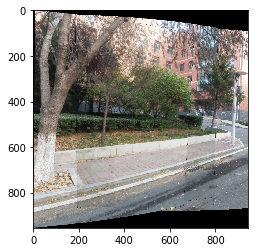

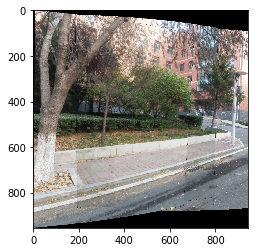

In [5]:
file_path = "pic/l_o"

class image_stitch():
    # 初始化
    def __init__(self,fea_extraction="SURF",bool_ghost=False,ghost_reduction="ghost_way1",bool_optimize=True,
                 optimizer="average",bool_cut=True):
        self.filename = file_path
        self.image = []
        self.image_gray = []
        self.image_order = []
        self.image_small = []
        self.feature_extraction = fea_extraction
        self.optimize_bool = bool_optimize
        self.optimizer = optimizer
        self.ghost_reduction_bool = bool_ghost
        self.ghost_reduction = ghost_reduction
        self.cut_bool = bool_cut
        #self.small_rate = 0.25
    
    def cylindricalWarpImage(self,img1,f=1200,savefig=False):
        #圆柱形状变换，输入彩色图像
        im_h,im_w,p = img1.shape
        K = np.array([[f, 0, im_w/2], [0, f, im_h/2], [0, 0, 1]])

        # go inverse from cylindrical coord to the image
        # (this way there are no gaps)
        cyl = np.zeros_like(img1)
        cyl_h,cyl_w,p = cyl.shape
        x_c = float(cyl_w) / 2.0
        y_c = float(cyl_h) / 2.0
        for x_cyl in np.arange(0,cyl_w):
            for y_cyl in np.arange(0,cyl_h):
                theta = (x_cyl - x_c) / f
                h     = (y_cyl - y_c) / f

                X = np.array([math.sin(theta), h, math.cos(theta)])
                X = np.dot(K,X)
                x_im = X[0] / X[2]
                if x_im < 0 or x_im >= im_w:
                    continue

                y_im = X[1] / X[2]
                if y_im < 0 or y_im >= im_h:
                    continue

                cyl[int(y_cyl),int(x_cyl)] = img1[int(y_im),int(x_im)]


        if savefig:
            plt.imshow(cyl[:,:,::-1])
            plt.savefig("cyl.png",bbox_inches='tight')

        return cyl
    
    
    
    
    # 下载图片
    def load_img(self):
        # 默认为jpg文件（手机拍摄）
        img_path = glob.glob(file_path + "/*jpg")
        print(img_path)
        # 信息采集程序拍摄图片png文件
        # img_path = glob.glob(file_path + "/*png")
        for i in range(len(img_path)):
            path_s = img_path[i]
            img = cv2.imread(path_s)
            h1, w1, p1 = img.shape
            if h1>=w1 and h1>1024 and w1>768:
                img = cv2.resize(img,(768,1024))
            elif h1<w1 and w1>1024 and h1>768:
                img = cv2.resize(img,(1024,768))
            img = self.cylindricalWarpImage(img)
            self.image.append(img)
            #print(img.shape)
            #img = cv2.resize(img,(int(w1*self.small_rate),int(h1*self.small_rate)))
            #self.image_small.append(img)
            img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            self.image_gray.append(img)

    # 图像测序
    def Image_sequencing(self):
        selected_img = []
        for n in range(len(self.image_gray)-1) : 
            s_id = -1
            m_id = -1
            best_score = -1

            for i in range(len(self.image_gray)):
                for j in range(len(self.image_gray)):
                    if i == j:
                        continue
                    if len(selected_img) != 0:
                        if (i!=selected_img[-1]) & (i!=selected_img[1]) & (i!=selected_img[-2]):
                            continue
                        if j in selected_img:
                            continue

                    I = np.fft.fft2(self.image_gray[i])
                    J = np.fft.fft2(self.image_gray[j])
                    C = np.fft.ifft2((I*np.conj(J))/np.sqrt(I*np.conj(I)*J*np.conj(J)))
                    C = np.abs(C)
                    score = np.max(C)
                    #print(i, " ", j, " ", score)
                    if score > best_score:
                        best_score = score
                        s_id = i
                        m_id = j

            selected_img.append(s_id)
            selected_img.append(m_id)
            
        self.image_order = []
        [self.image_order.append(i) for i in selected_img if not i in self.image_order]
        #print(self.image_order)
        

    # 运行
    def run(self):
        start=time.time()
        self.load_img()
        stop=time.time()
        print("图片读取并修饰时间"+str(stop-start)+"秒")
        start=time.time()
        self.Image_sequencing()
        stop=time.time()
        print(self.image_order)
        print("测序时间"+str(stop-start)+"秒")
        x = input("请输入1<=x<="+str(len(self.image)-1)+"以查看第x次拼接结果：")

        final_image = None
        # 构建拼接算法
        mosaic = image_mosaic(self.feature_extraction,"./output")

        for i in range(1,len(self.image_order)):
            if i == 1:
                start=time.time()
                mosaic.img1 = self.image[self.image_order[1]]
                mosaic.img2 = self.image[self.image_order[0]]
                mosaic.mosaic()
                start_cut=time.time()
                mosaic.image_cut()
                stop_cut=time.time()
                print("此次修剪/融合需要"+str(stop_cut-start_cut)+"秒")
                final_image = mosaic.img_final
                stop=time.time()
                plt.figure("最终拼接结果")
                plt.imshow(final_image[:,:,::-1])
                if len(self.image_order) == 2:
                    cv2.imwrite(mosaic.outpath+"/final"+"/finall.jpg",final_image)
                print("第"+str(i)+"次拼接需要"+str(stop-start)+"秒")
            else:
                start=time.time()
                mosaic.img1 = self.image[self.image_order[i]]
                mosaic.img2 = final_image
                mosaic.mosaic()
                start_cut=time.time()
                mosaic.image_cut()
                stop_cut=time.time()
                print("此次修剪/融合需要"+str(stop_cut-start_cut)+"秒")
                final_image = mosaic.img_final
                stop=time.time()
                plt.figure("最终拼接结果")
                plt.imshow(final_image[:,:,::-1])
                if i == (len(self.image_order)-1):
                    cv2.imwrite(mosaic.outpath+"/final"+"/finall.jpg",final_image)
                print("第"+str(i)+"次拼接需要"+str(stop-start)+"秒")
            if len(x) == 0:
                continue
            if i == int(x):
                plt.figure("第"+str(x)+"次拼接图")
                plt.imshow(final_image[:,:,::-1])

        '''
        final_image = mosaic.mosaic_fusion(self.image[2], self.image[1])
        cv2.imshow("mind",final_image)
        final_image = mosaic.mosaic_fusion(final_image, self.image[3])
        final_image = mosaic.mosaic_fusion(final_image, self.image[0])
        '''
        
        cv2.imwrite("final_im_end.png",final_image)
        plt.imshow(final_image[:,:,::-1])


if __name__ == "__main__":
    start_all=time.time()
    # 通过传入参数改变拼接方法（空为默认参数）
    image_stitch().run()
    stop_all=time.time()
    print("程序运行需要"+str(stop_all-start_all)+"秒")

## 